In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, roc_curve, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Read in the training data
train_features = pd.read_csv('training_set_features.csv')
train_labels = pd.read_csv("training_set_labels.csv")

# Train Features

In [3]:
train_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [5]:
train_features.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000


# Training Labels

In [6]:
train_labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [7]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


In [8]:
train_labels["h1n1_vaccine"].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

H1N1 vaccine is highly imbalanced

In [9]:
train_labels["seasonal_vaccine"].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

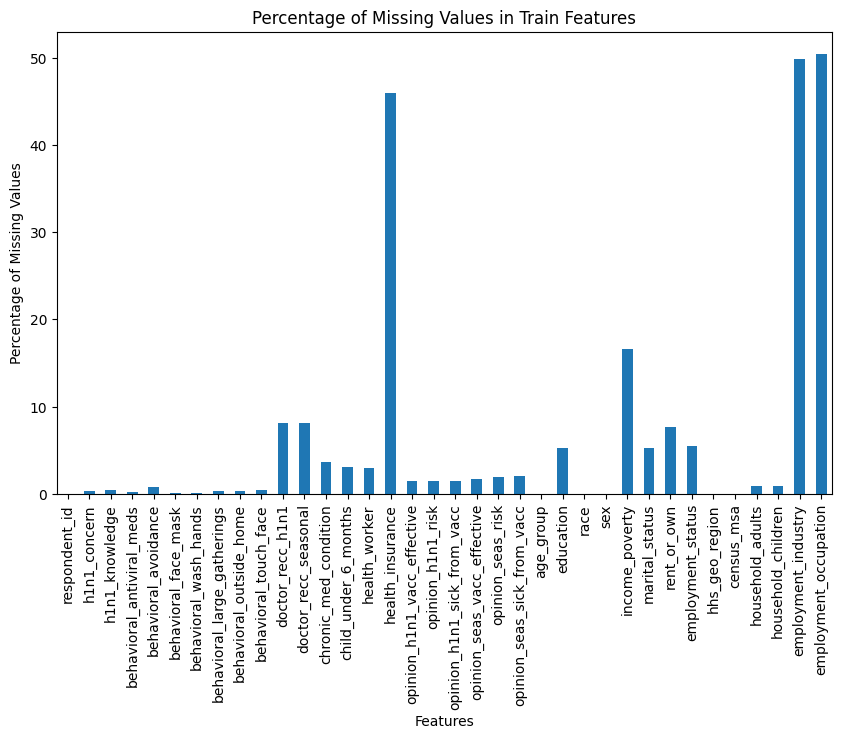

In [10]:
import matplotlib.pyplot as plt

missing_values_percentage = train_features.isnull().mean() * 100
missing_values_percentage.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Train Features')
plt.show()

In [11]:
train_features.drop(["employment_industry", "employment_occupation",'health_insurance'], axis=1, inplace=True)

In [18]:
survey_data = train_features.merge(right=train_labels, how='inner', on='respondent_id')
survey_data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0


<AxesSubplot: xlabel='race'>

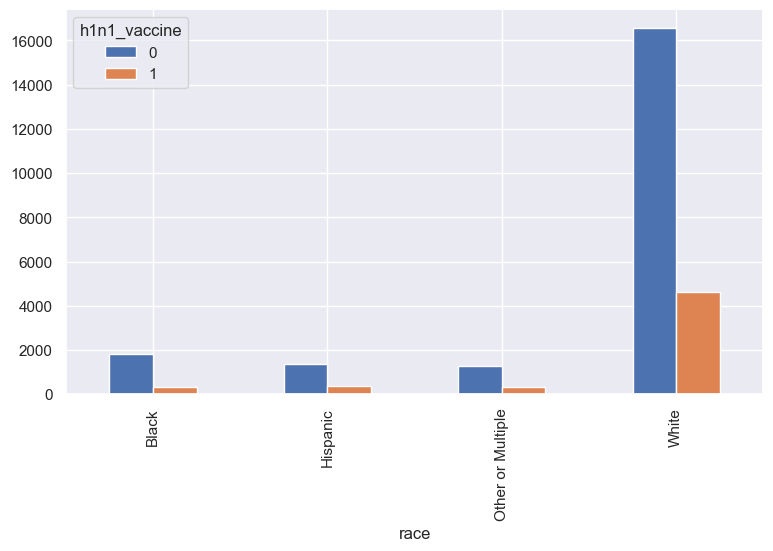

In [22]:
vaccine_by_race = survey_data.groupby(['race', 'h1n1_vaccine'])['h1n1_vaccine'].count()
vaccine_by_race.unstack().plot(kind='bar')

<AxesSubplot: xlabel='race'>

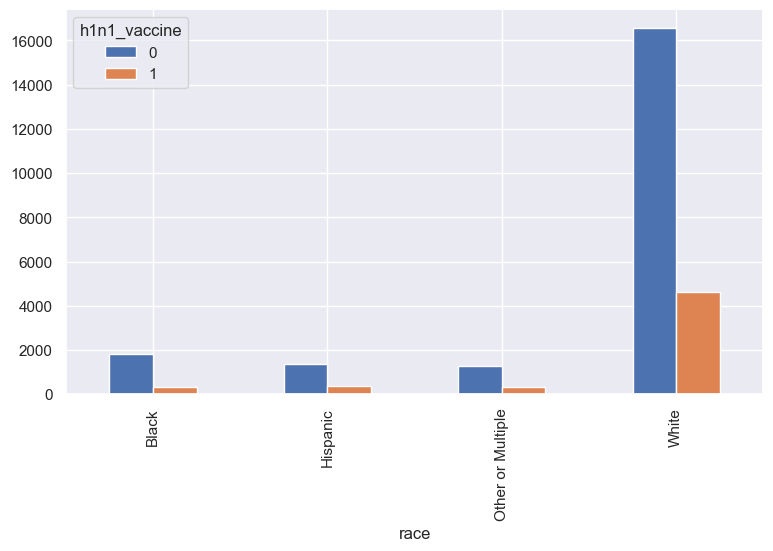

In [23]:
vaccine_by_age = survey_data.groupby(['age_group', 'h1n1_vaccine'])['h1n1_vaccine'].count()
vaccine_by_age.unstack().plot(kind='bar')

<AxesSubplot: xlabel='doctor_recc_seasonal'>

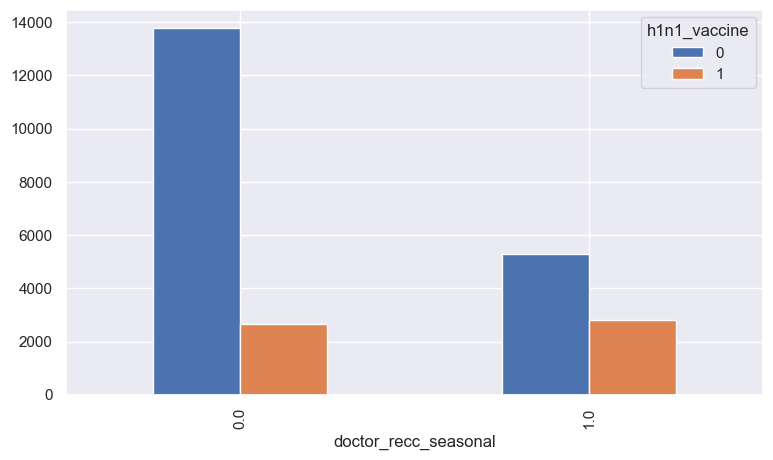

In [24]:
vaccine_by_recc = survey_data.groupby(['doctor_recc_seasonal', 'h1n1_vaccine'])['h1n1_vaccine'].count()
vaccine_by_recc.unstack().plot(kind='bar')

In [26]:
from sklearn.model_selection import train_test_split

X = survey_data.drop(columns=['respondent_id','seasonal_vaccine', 'h1n1_vaccine'])
y = survey_data['h1n1_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=1)

In [27]:
def get_imp(X, type='train'):

    if type == 'test':
        array = imp.transform(X)
    else:
        array = imp.fit_transform(X)

    X_imp = pd.DataFrame(array,
                         index=X.index,
                         columns=X.columns)
    
    return X_imp

def get_ohe(X, type='train'):

    if type == 'test':
        array = ohe.transform(X)
    else:
        array = ohe.fit_transform(X)

    X_ohe = pd.DataFrame(array,
                         index=X.index)
    X_ohe.columns = ohe.get_feature_names(X.columns)

    return X_ohe




imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False)

X_train_imp = get_imp(X_train, type='train')
X_train_imp_ohe = get_ohe(X_train_imp, type='train')
X_test_imp = get_imp(X_test, type='test')
X_test_imp_ohe = get_ohe(X_test_imp, type='test')

In [31]:
X_train_imp_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21365 entries, 22542 to 235
Columns: 109 entries, h1n1_concern_0.0 to household_children_3.0
dtypes: float64(109)
memory usage: 17.9 MB


# Baseline Model

In [32]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1)
model_log = logreg.fit(X_train_imp_ohe, y_train)
model_log

LogisticRegression(random_state=1)

In [34]:
class ModelValidation(metaclass=type):

    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        y_train_pred = logreg.predict(X_train)
        y_test_pred = logreg.predict(X_test)

        y_train_resid = np.abs(y_train - y_train_pred)
        y_test_resid = np.abs(y_test - y_test_pred)
        
        self.train_accuracy = pd.Series(y_train_resid).value_counts(normalize=True)[0]
        self.test_accuracy = pd.Series(y_test_resid).value_counts(normalize=True)[0]

    def plot_train_matrix(self):
        return plot_confusion_matrix(logreg, self.X_train, self.y_train)

    def plot_test_matrix(self):
        return plot_confusion_matrix(logreg, self.X_test, self.y_test)

    def plot_auc(self):
        y_score = logreg.fit(self.X_train, self.y_train).decision_function(self.X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)

        print('AUC: {}'.format(auc(fpr, tpr)))

        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        print('AUC: {}'.format(auc(fpr, tpr)))
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        

mv = ModelValidation(X_train_imp_ohe, X_test_imp_ohe, y_train, y_test)
mv

In [41]:
def get_y_pred(X_transformed, y):
    y_pred = logreg.predict(X_transformed)
    residuals = np.abs(y - y_pred)
    print(pd.Series(residuals, name="Residuals (Counts)").value_counts())
    print()
    print(f"Accuracy: {pd.Series(residuals, name='Accuracy').value_counts(normalize=True)[0]}")

    return y_pred

In [42]:
y_train_pred = get_y_pred(X_train_imp_ohe, y_train)

0    17847
1     3518
Name: Residuals (Counts), dtype: int64

Accuracy: 0.8353381699040486


In [43]:
y_test_pred = get_y_pred(X_test_imp_ohe, y_test)

0    4504
1     838
Name: Residuals (Counts), dtype: int64

Accuracy: 0.8431299138899289


              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4220
           1       0.71      0.43      0.54      1122

    accuracy                           0.84      5342
   macro avg       0.78      0.69      0.72      5342
weighted avg       0.83      0.84      0.83      5342



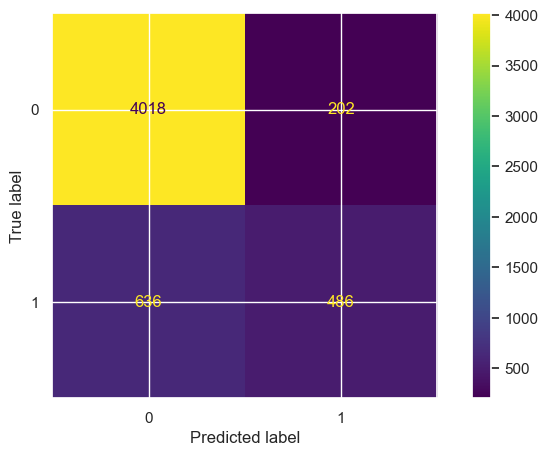

In [44]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(logreg, X_test_imp_ohe, y_test)
print(classification_report(y_test, y_test_pred))

In [45]:
from sklearn.model_selection import cross_val_score

X_imp = get_imp(X)
X_imp_ohe = get_ohe(X_imp)

cross_val_score(logreg, X_imp_ohe, y, cv=5)

array([0.83564208, 0.83302134, 0.83710916, 0.83973039, 0.83224115])

AUC: 0.8366515024794924
AUC: 0.8366515024794924


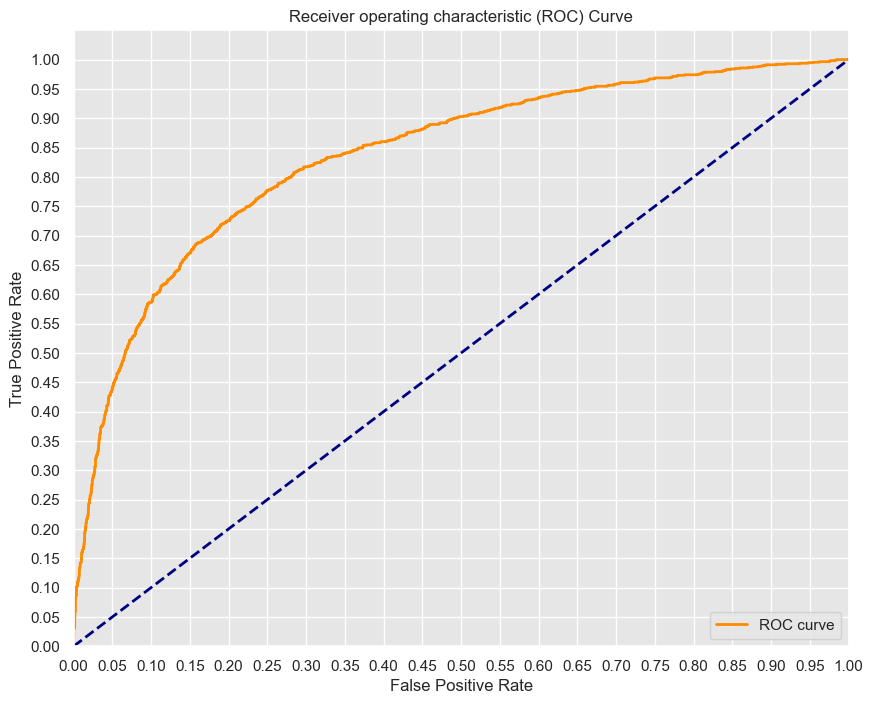

In [48]:
 from sklearn.metrics import roc_curve, auc

%matplotlib inline
y_score = logreg.fit(X_train_imp_ohe, y_train).decision_function(X_test_imp_ohe)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC: {}'.format(auc(fpr, tpr)))

# # Seaborn's beautiful styling
 sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Logistic Regression Model

# Decision Tree Model